In [1]:
import pandas as pd

### Data Loading and Visualization

In [2]:
train_set = "imdb_urdu_reviews_train.csv"
test_set = "imdb_urdu_reviews_test.csv"

In [3]:
train_df = pd.read_csv(train_set)
test_df = pd.read_csv(test_set)
train_df.head()

,review,sentiment
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive


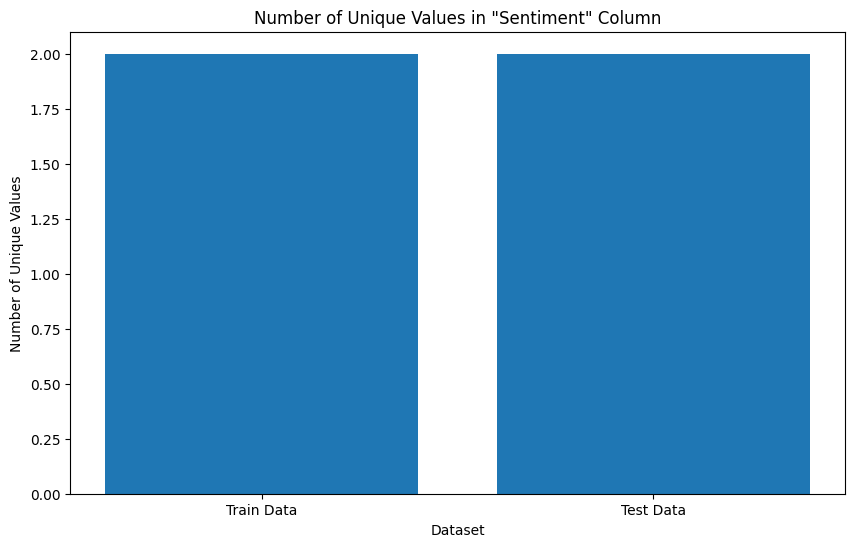

Unique values and their counts in 'Sentiment' column for Train Data:
sentiment
negative    20082
positive    19918
Name: count, dtype: int64

Unique values and their counts in 'Sentiment' column for Test Data:
sentiment
positive    5082
negative    4918
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt

train_unique_counts = train_df['sentiment'].value_counts()
test_unique_counts = test_df['sentiment'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(['Train Data', 'Test Data'], [len(train_unique_counts), len(test_unique_counts)])
plt.xlabel('Dataset')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values in "Sentiment" Column')
plt.show()
print("Unique values and their counts in 'Sentiment' column for Train Data:")
print(train_unique_counts)
print("\nUnique values and their counts in 'Sentiment' column for Test Data:")
print(test_unique_counts)

### MODEL

In [5]:
import warnings
warnings.filterwarnings("ignore")
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

#### Preprocessing

In [6]:
def preprocess_text(text):
    text = re.sub(r"[A-Za-z0-9]+", '', text)  # Remove English letters and numerics
    return text.lower().strip()

# Apply preprocessing to the 'review' column in train_df and test_df
train_df['review'] = train_df['review'].apply(preprocess_text)
test_df['review'] = test_df['review'].apply(preprocess_text)


#### Tokenization and Padding

In [7]:
# Tokenization and Padding
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['review'])

train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])

max_length = 50
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


#### Model Definition


In [8]:
# Model Definition
embedding_dim = 32
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, None, 128)         82432     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 451905 (1.72 MB)
Trainable params: 451905 (1.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model Training

In [9]:
# Model Training
X_train, y_train = train_padded, (train_df['sentiment'] == 'positive').astype(int)
X_test, y_test = test_padded, (test_df['sentiment'] == 'positive').astype(int)

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 144s 109ms/step - loss: 0.5657 - accuracy: 0.6995 - val_loss: 0.5204 - val_accuracy: 0.7399
Epoch 2/10
1250/1250 [==============================] - 102s 81ms/step - loss: 0.4645 - accuracy: 0.7790 - val_loss: 0.5159 - val_accuracy: 0.7491
Epoch 3/10
1250/1250 [==============================] - 99s 79ms/step - loss: 0.4106 - accuracy: 0.8093 - val_loss: 0.5347 - val_accuracy: 0.7392
Epoch 4/10
1250/1250 [==============================] - 101s 81ms/step - loss: 0.3537 - accuracy: 0.8412 - val_loss: 0.5440 - val_accuracy: 0.7405
Epoch 5/10
1250/1250 [==============================] - 100s 80ms/step - loss: 0.2895 - accuracy: 0.8771 - val_loss: 0.6984 - val_accuracy: 0.7290
Epoch 6/10
1250/1250 [==============================] - 111s 89ms/step - loss: 0.2325 - accuracy: 0.9033 - val_loss: 0.6889 - val_accuracy: 0.7196
Epoch 7/10
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1862 - accuracy: 0.9259 - val_loss: 0

#### Model Evaluation

In [14]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

313/313 [==============================] - 18s 56ms/step - loss: 1.2452 - accuracy: 0.7069
Test Accuracy: 0.7069000005722046


#### Model Inference

In [15]:
# Inference I Guess
# new_text = "یہ کرنا ایک بری چیز ہے۔"
new_text = "یہ کرنا ایک اچھی چیز ہے۔" # positive test

new_text = preprocess_text(new_text)

new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded = pad_sequences(new_sequence, maxlen=max_length, padding='post', truncating='post')

prediction = model.predict(new_padded)
print(prediction[0][0])

if prediction[0][0] >= 0.5:
    sentiment = 'POSITIVE'
else:
    sentiment = 'NEGATIVE'

print(f"The sentiment of the input text is: {sentiment}")

1/1 [==============================] - 0s 85ms/step
0.9970922
The sentiment of the input text is: POSITIVE


In [16]:
# Inference I Guess
new_text = "یہ کرنا ایک بری چیز ہے۔"
# new_text = "یہ کرنا ایک اچھی چیز ہے۔" # positive test

new_text = preprocess_text(new_text)

new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded = pad_sequences(new_sequence, maxlen=max_length, padding='post', truncating='post')

prediction = model.predict(new_padded)
print(prediction[0][0])

if prediction[0][0] >= 0.5:
    sentiment = 'POSITIVE'
else:
    sentiment = 'NEGATIVE'

print(f"The sentiment of the input text is: {sentiment}")

1/1 [==============================] - 0s 40ms/step
0.01119917
The sentiment of the input text is: NEGATIVE


#### Save the tokens and model for standalone usage

In [13]:
# Save model and Tokens
model.save("urduModel.h5")
train_df['review']
train_df[['review']].to_csv('tokens.csv', index=False)